In [1]:
import brian2
from brian2tools import *
from brian2 import *
from struct import unpack
from PIL import Image
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import os.path
import pickle as pickle
import scipy
import scipy.signal as signal
import time
import warnings
warnings.simplefilter('ignore')
import gc
gc.collect()

1437

In [2]:
def gaussian2D(x, y, sigma):
    return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/(sigma**2))*(x**2 + y**2))

def mexicanHat(x,y,sigma1,sigma2): 
    return gaussian2D(x,y,sigma1) - gaussian2D(x,y,sigma2)

def receptiveFieldMatrix(func):
    h = 7
    g = np.zeros((h,h))
    for xi in range(0,h):
        for yi in range(0,h):
            x = xi-int(h/2)
            y = yi-int(h/2)
            g[xi, yi] = func(x,y);
    return g

In [3]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
#     print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [4]:
def get_stimuli_strip(j, o_index, shape):
    f = 75
    matrix = np.zeros(shape)
    mt = matrix.transpose()
    if (o_index == h_index):
        mt[h_index][:,j] += f

    elif (o_index == v_index):
        mt[v_index][j,:] += f

    elif (o_index == d1_index):
        if(j < c_length):
            for i in range(j + 1):
                mt[d1_index][i][j - i] += f
        else:
            grid_h = j - c_length + 1
            grid_v = c_length - 1
            for i in range(grid_h, c_length):
                mt[d1_index][i][grid_v] += f
                grid_v -= 1

    elif (o_index == d2_index):
        if(j < c_length):
            h_grid = c_length - 1
            for i in range(j + 1):
                mt[d2_index][h_grid][j - i] += 1.2*f
                h_grid -= 1
        else:
            grid_h = 2*(c_length - 1) - j
            grid_v = c_length - 1
            for i in range(grid_h, -1, -1):
                mt[d2_index][i][grid_v] += f
                grid_v -= 1        

    matrix = mt.transpose()
    return matrix

In [5]:
def save_connections():
    for connName in connections:
        conn = connections[connName]
        weights = np.column_stack((conn.i, conn.j, conn.w))
        sparseWeights = weights[~(weights.transpose()[2] == 0)]
        np.save(saved_path + connName, sparseWeights)
        print(connName, end=' ')
    print('connections saved')

In [6]:
def get_surrounding(coordinate, r, inner, length):
    y = coordinate[0]
    x = coordinate[1]
    
    x_min = 0 if (x-r < 0) else (x-r)
    x_max = (length-1) if (x+r > length-1) else (x+r)
    y_min = 0 if (y-r < 0) else (y-r)
    y_max = (length-1) if (y+r > length-1) else (y+r)
    
    coordinates = []
    for i in range(y_min, y_max+1):
        for j in range(x_min, x_max+1):
            if (i==y and j==x and not inner):
                continue
            coordinates.append((i,j))
            
    return coordinates

def get_prefered_surrounding(coordinate, o_index, c_length):
    x = coordinate[0]
    y = coordinate[1]
    
    arr = []
    if (o_index == h_index):
        arr = [(x,y-2), (x,y-1), (x,y+1), (x,y+2)]
    elif (o_index == v_index):
        arr = [(x-2,y), (x-1,y), (x+1,y), (x+2,y)]
    elif (o_index == d1_index):
        arr = [(x+2,y-2), (x+1,y-1), (x-1,y+1), (x-2,y+2)]
    elif (o_index == d2_index):
        arr = [(x+2,y+2), (x+1,y+1), (x-1,y-1), (x-2,y-2)]
    
    coordinates = []
    for (p,q) in arr:
        if ((p>-1 and p<c_length) and (q>-1 and q<c_length)):
            coordinates.append((p,q))
    return coordinates

In [7]:
def plot_lateral_distribution(name):
    weights = np.array(connections[name].w)
    weights = weights.reshape(shape)
    
    # init dictionary
    list_dic = {}; sum_dic = {}; total_sum = 0
    
    c = {0:'h', 1:'v', 2:'d1', 3:'d2'}
    for s_index in range(orientations):
        for t_index in range(orientations):
            list_dic[c[s_index]+c[t_index]] = []
            sum_dic[c[s_index]+c[t_index]] = 0

    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), lateral_range, False, c_length):
                
                for s_index in range(orientations):
                    for t_index in range(orientations):
                        target = ( p * c_length + q ) * orientations + t_index
                        source = ( i * c_length + j ) * orientations + s_index
                        list_dic[c[s_index]+c[t_index]].append(weights[source][target])
                        sum_dic[c[s_index]+c[t_index]] += abs(weights[source][target])
                        total_sum += abs(weights[source][target])
                        
    category_names = ['H', 'V', 'Diagonal (45)', 'Diagonal (135)']
    results = { 'h': [], 'v': [], 'd1': [], 'd2': [] }
    %run horizontal_barchart_distribution.py
                        
    plt.figure(figsize=(17,4))
    for s_index in range(orientations):
        for t_index in range(orientations):
            plt.plot(list_dic[c[s_index]+c[t_index]], label=c[s_index]+c[t_index])
            
            print(c[s_index]+c[t_index], sum_dic[c[s_index]+c[t_index]], 
                  'of', total_sum, ':', sum_dic[c[s_index]+c[t_index]]*100/total_sum)
            
            results[c[s_index]].append(sum_dic[c[s_index]+c[t_index]])
    
    plt.legend(); plt.show()
    survey(results, category_names)

In [8]:
def plot_preferred_distribution():
    c = {0:'horizontal', 1:'vertical', 2:'diagonal 45', 3:'diagonal 135'}
        
    weights = np.array(connections['L3_L3'].w)
    weights = weights.reshape(shape)
    
    # init dictionary
    w_arr = [[], [], [], []]
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for o_index in range(orientations):
                for p,q in get_prefered_surrounding((i,j), o_index, c_length):
                    target = ( p * c_length + q ) * orientations + o_index
                    source = ( i * c_length + j ) * orientations + o_index
                    w_arr[o_index].append(weights[source][target])
                        
    plt.figure(figsize=(17,12))
    for o_index in range(orientations):
        plt.subplot(4, 1, o_index+1)
        plt.plot(w_arr[o_index], label=c[o_index])
        plt.legend()
        print(c[o_index], ' - ', sum(w_arr[o_index]))
    
    plt.show()
    gc.collect()

In [9]:
def normalize_prefered_weights(o_index):
    weights = np.array(connections['L3_L3'].w)
    weights = weights.reshape((n_L3, n_L3))
    
    penalize_self(weights, (n_L3, n_L3))
    
    w_ar = np.array([])
    
    count = 0;
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_prefered_surrounding((i,j), o_index, c_length):
                target = ( p * c_length + q ) * orientations + o_index
                source = ( i * c_length + j ) * orientations + o_index
                w_ar = np.append(w_ar, weights[source][target])
                count += 1
    print('o_index', o_index,'count',count)
    
    q90 = np.percentile(w_ar, 85)
    q10 = np.percentile(w_ar, 10)
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_prefered_surrounding((i,j), o_index, c_length):
                target = ( p * c_length + q ) * orientations + o_index
                source = ( i * c_length + j ) * orientations + o_index
                if (weights[source][target] > q90):
                    weights[source][target] = q90
                elif (weights[source][target] < q10):
                    weights[source][target] = q10
    
    weights = weights.reshape((n_L3*n_L3))
    connections['L3_L3'].w = weights
    gc.collect()
    
#     print('average', sum(w_ar)/count);

In [10]:
def penalize_self(weights, shape):
    for i in range(shape[0]):
        weights[i][i] *= 0.5
    return weights

In [11]:
def change_weights(update_value):
    shape = (n_L3, n_L3)
    weights = np.array(connections['L3_L3'].w)
    weights = weights.reshape(shape)
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for o_index in range(orientations):
                for p,q in get_prefered_surrounding((i,j), o_index, c_length):
                    target = ( p * c_length + q ) * orientations + o_index
                    source = ( i * c_length + j ) * orientations + o_index
                    weights[source][target] = update_value
                        
    weights = weights.reshape((n_L3*n_L3))
    connections['L3_L3'].w = weights
    gc.collect()

# INITIALIZE

In [12]:
initial_path = './initial_weights/'
saved_path = './saved_weights/'

fig_num = 1

field_size = 5                     # 2/3/4/5/6
margin = (field_size//2)

c_length = 20
r_length = c_length + margin*2
orientations = 4
h_index = 0
v_index = 1
d1_index = 2
d2_index = 3

n_L4  = c_length*c_length*orientations
n_L3  = n_L4
n_L2  = n_L3

lateral_range = 2

epochs = 1
# num_epochs = 20
# normalize_interval = 20

single_example_time = 0.45 * second
resting_time = 0.25 * second

delay = {}
delay = (0*ms, 5*ms)              # min and max delay
minDelay = delay[0]
maxDelay = delay[1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 20. * ms
refrac_i = 15. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.2 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 50*ms
tc_post = 40*ms
nu_pre =  0.05# 0.0001
nu_post = 0.15 # 0.01
wmax = 100.0
Apre = 0.4
Apost = Apre*1.05

input_intensity = 1.
start_input_intensity = input_intensity

#membrane dynamics
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

# learning rules
# without STDP
model = 'w : 1'
pre_e = 'g_e_post += w'
pre_i = 'g_i_post += w'
post = ''

stdp_model = '''
    post2_temp                          : 1
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost/dt  =   -post/(tc_post)       : 1 (event-driven)
'''
stdp_pre = '''
    w = clip(w + nu_pre*post, -wmax, wmax) * int(post>0.3*Apost) + clip(w - nu_pre*post, -wmax, wmax) * int(post<=0.3*Apost);
    pre += Apre;
'''
stdp_pre_e = stdp_pre + 'g_e_post += w;'
stdp_pre_i = stdp_pre + 'g_i_post += w;'
stdp_post  = 'w = clip(w + nu_post * pre, 0, wmax); post += Apost;'

In [13]:
# stimuli_on, stimuli_off = load_stimuli('./pic_60_1.tif')

In [14]:
neuron_groups = {}
neuron_groups_list = [
    ('L4', 'e'), ('L3', 'e'), ('L2', 'i')
]

for name, e_i in neuron_groups_list:
    if (e_i == 'e'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
        neuron_groups[name].v = v_rest_e - 40.*mV 
        neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
    elif (e_i == 'i'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
        neuron_groups[name].v = v_rest_i - 40.*mV 

input_groups = {}
input_groups['input']   = PoissonGroup(n_L4, 0*Hz)

gc.collect()

1635

In [15]:
weight_path = initial_path
# weight_path = saved_path
connections = {}
#[name, shape, weight_file, source, target, equation_type]

# From input to neruon groups (L4)
weightMatrix = get_matrix_from_file(weight_path + 'L4_L4.npy', (n_L4, n_L4))
connections['input_L4']= Synapses(input_groups['input'], neuron_groups['L4'], model=model, on_pre=pre_e, on_post=post)
connections['input_L4'].connect(True)
connections['input_L4'].w = weightMatrix[connections['input_L4'].i, connections['input_L4'].j]
# connections['input_L4'].delay = 'maxDelay'
    
neuron_neuron_conn = [
    ['L4_L3', (n_L4, n_L3), 'L4_L3.npy', 'L4', 'L3', 'e', False],
    ['L3_L3', (n_L3, n_L3), 'L3_L3.npy', 'L3', 'L3', 'e', True],
    ['L3_L2', (n_L3, n_L2), 'L3_L2.npy', 'L3', 'L2', 'e', False],
    ['L2_L3', (n_L2, n_L3), 'L2_L3.npy', 'L2', 'L3', 'i', False],
    ['L3_L4', (n_L3, n_L4), 'L3_L4.npy', 'L3', 'L4', 'e', False]
]
    
for name, shape, weight_file, source, target, equation, learn in neuron_neuron_conn:
    if (learn):
        model_eq = stdp_model
        post_eq = stdp_post
        if (equation == 'e'):
            pre_eq = stdp_pre_e
        elif (equation == 'i'):
            pre_eq = stdp_pre_i
    else:
        model_eq = model
        post_eq = post
        if (equation == 'e'):
            pre_eq = pre_e
        elif (equation == 'i'):
            pre_eq = pre_i
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(neuron_groups[source], neuron_groups[target], model=model_eq, on_pre=pre_eq, on_post=post_eq)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
    
gc.collect()

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


1474

In [16]:
spike_monitors = {}
spike_monitors['input'] = SpikeMonitor(input_groups['input'])
for name,_ in neuron_groups_list:
    spike_monitors[name] = SpikeMonitor(neuron_groups[name])
    
M = {}
# M['L3_L3'] = StateMonitor(connections['L3_L3'], ['w'], record=True)
# M['L3_L2'] = StateMonitor(connections['L3_L2'], ['w', 'post', 'pre'], record=True)
# M['L3'] = StateMonitor(neuron_groups['L3'], ['v', 'g_e', 'g_i'], record=True)
# M['L2'] = StateMonitor(neuron_groups['L2'], ['v', 'g_e', 'g_i'], record=True)

In [17]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, spike_monitors, M]:
    for key in obj_list:
        net.add(obj_list[key])

In [18]:
change_weights(10.60)

horizontal  -  15687.999999999996
vertical  -  15687.999999999996
diagonal 45  -  14521.999999999998
diagonal 135  -  14521.999999999998


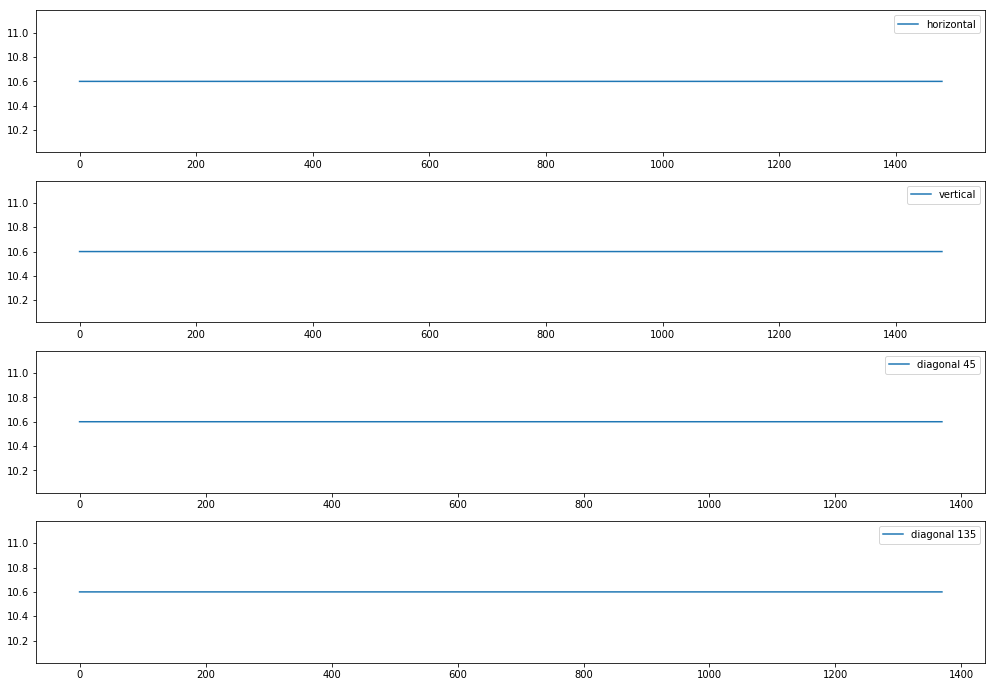

In [19]:
plot_preferred_distribution()

# TRAIN

In [20]:
previous_spike_count = np.zeros(n_L4)
input_groups['input'].rates = 0 * Hz

for iteration in range(epochs*orientations):
    o_index = iteration%orientations
    if (o_index == h_index or o_index == v_index):
        num_epochs = c_length
    elif (o_index == d1_index or o_index == d2_index):
        num_epochs = c_length*2 - 1
#     num_epochs = c_length
    
    net.run(resting_time)
    
    for name, e_i in neuron_groups_list:
        if (e_i == 'e'):
            neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV

    j = 0
    while j < (num_epochs):
        prenatal_stimuli = get_stimuli_strip(j, o_index, (c_length,c_length,orientations))
        
        spike_rates = prenatal_stimuli.reshape((n_L4)) / 8. *  input_intensity
        input_groups['input'].rates = spike_rates * Hz

        print('run example number:', j+1, 'of', num_epochs, 'in iteration', iteration, 'of', epochs*orientations)
        
        net.run(single_example_time, report='text')   # 0.35 s

        current_spike_count = np.asarray(spike_monitors['L4'].count[:]) - previous_spike_count
        previous_spike_count = np.copy(spike_monitors['L4'].count[:])
        
        input_groups['input'].rates = 0 * Hz
        net.run(resting_time) 

        if np.sum(current_spike_count) < 1:
            if (input_intensity == 5):
                break;
            print("F - spike count", np.sum(current_spike_count))
            input_intensity += 1
        else:     
            print("S - spike count", np.sum(current_spike_count))
            input_intensity = start_input_intensity
            j += 1
            
        if (j != 0 and (j)%num_epochs == 0):
#             normalize_weights(o_index)
            normalize_prefered_weights(o_index)
        
        # garbage collect after each iteration
        gc.collect()
    
#     if (iteration != 0 and (iteration+1)%orientations == 0):
#         normalize_weights()

run example number: 1 of 20 in iteration 0 of 4
Starting simulation at t=250. ms for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 34.0
run example number: 2 of 20 in iteration 0 of 4
Starting simulation at t=0.95 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 37
run example number: 3 of 20 in iteration 0 of 4
Starting simulation at t=1.65 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 42
run example number: 4 of 20 in iteration 0 of 4
Starting simulation at t=2.35 s for a duration of 0.45 s
0.45 (100%) simulated in 3s
S - spike count 37
run example number: 5 of 20 in iteration 0 of 4
Starting simulation at t=3.05 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 34
run example number: 6 of 20 in iteration 0 of 4
Starting simulation at t=3.75 s for a duration of 0.45 s
0.45 (100%) simulated in 4s
S - spike count 37
run example number: 7 of 20 in iteration 0 of 4
Starting simulation at t=4.45 s for a

0.45 (100%) simulated in 5s
S - spike count 24
run example number: 15 of 39 in iteration 2 of 4
Starting simulation at t=38.55 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 29
run example number: 16 of 39 in iteration 2 of 4
Starting simulation at t=39.25 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 31
run example number: 17 of 39 in iteration 2 of 4
Starting simulation at t=39.95 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 34
run example number: 18 of 39 in iteration 2 of 4
Starting simulation at t=40.65 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 31
run example number: 19 of 39 in iteration 2 of 4
Starting simulation at t=41.35 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 44
run example number: 20 of 39 in iteration 2 of 4
Starting simulation at t=42.05 s for a duration of 0.45 s
0.45 (100%) simulated in 5s
S - spike count 38
run example number: 21 of 39 

Starting simulation at t=75.9 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 21
run example number: 30 of 39 in iteration 3 of 4
Starting simulation at t=76.6 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 16
run example number: 31 of 39 in iteration 3 of 4
Starting simulation at t=77.3 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 18
run example number: 32 of 39 in iteration 3 of 4
Starting simulation at t=78. s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 12
run example number: 33 of 39 in iteration 3 of 4
Starting simulation at t=78.7 s for a duration of 0.45 s
0.45 (100%) simulated in 6s
S - spike count 15
run example number: 34 of 39 in iteration 3 of 4
Starting simulation at t=79.4 s for a duration of 0.45 s
0.45 (100%) simulated in 7s
S - spike count 9
run example number: 35 of 39 in iteration 3 of 4
Starting simulation at t=80.1 s for a duration of 0.45 s
0.45 (100%) simulated in 7s

L3_max 3 L3_min 0
L4_max 3 L4_min 0


0

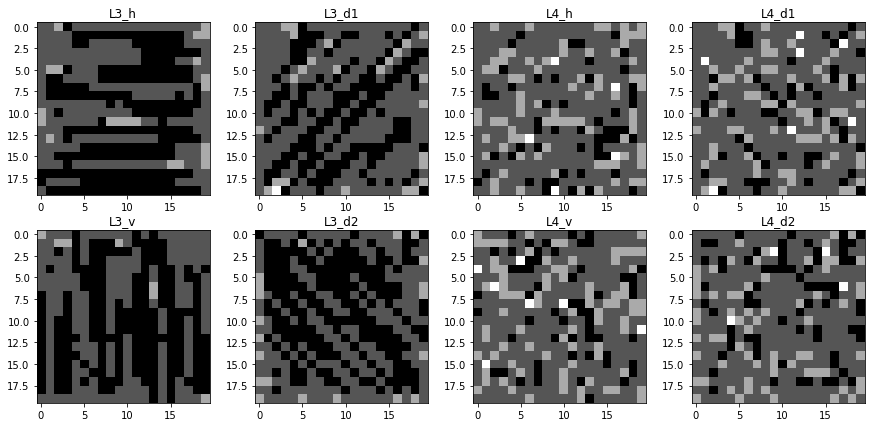

In [21]:
c_shape = (c_length, c_length, orientations)
fig, axarr = subplots(2,4, figsize = (15, 7))

data = np.copy(spike_monitors['L3'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()
print('L3_max', v_max, 'L3_min', v_min)

axarr[0,0].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,0].title.set_text('L3_h')
axarr[1,0].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,0].title.set_text('L3_v')
axarr[0,1].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,1].title.set_text('L3_d1')
axarr[1,1].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,1].title.set_text('L3_d2')


data = np.copy(spike_monitors['L4'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()
print('L4_max', v_max, 'L4_min', v_min)

axarr[0,2].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,2].title.set_text('L4_h')
axarr[1,2].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,2].title.set_text('L4_v')
axarr[0,3].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,3].title.set_text('L4_d1')
axarr[1,3].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,3].title.set_text('L4_d2')

gc.collect()

hh 17907.516484911746 of 100226.45430962848 : 17.86705576712337
hv 2573.3042967182314 of 100226.45430962848 : 2.567490104726793
hd1 2572.821246114551 of 100226.45430962848 : 2.5670081455404605
hd2 2573.2572132577184 of 100226.45430962848 : 2.5674431276478993
vh 2573.249996765746 of 100226.45430962848 : 2.5674359274610605
vv 17916.2149873062 of 100226.45430962848 : 17.875734615890767
vd1 2573.301424170143 of 100226.45430962848 : 2.567487238669016
vd2 2572.9276032635903 of 100226.45430962848 : 2.567114262383336
d1h 2572.7545500989036 of 100226.45430962848 : 2.56694160021956
d1v 2572.7912555331986 of 100226.45430962848 : 2.5669782227206235
d1d1 16760.36879939859 of 100226.45430962848 : 16.72249997752187
d1d2 2573.0884863048345 of 100226.45430962848 : 2.567274781921169
d2h 2572.671459533175 of 100226.45430962848 : 2.56685869739086
d2v 2573.4665332263776 of 100226.45430962848 : 2.5676519746734687
d2d1 2572.7798938248834 of 100226.45430962848 : 2.5669668866832533
d2d2 16765.940079199216 of 1

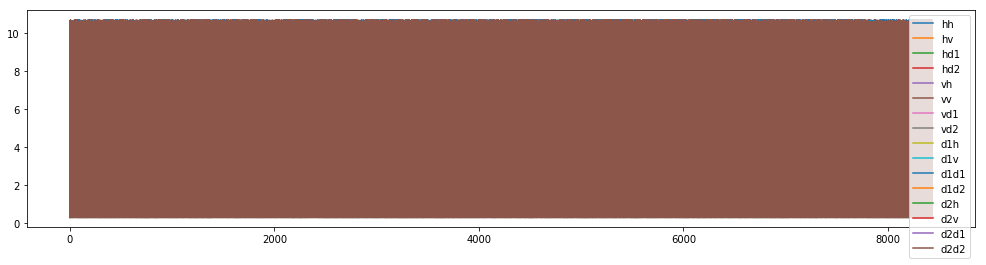

4713

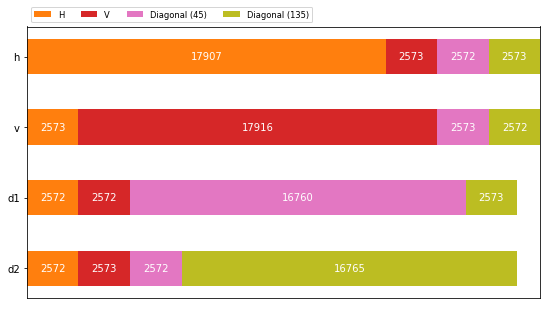

In [22]:
plot_lateral_distribution('L3_L3')
gc.collect()

horizontal  -  15785.590247481385
vertical  -  15794.340342594116
diagonal 45  -  14604.965458997329
diagonal 135  -  14610.721713694204


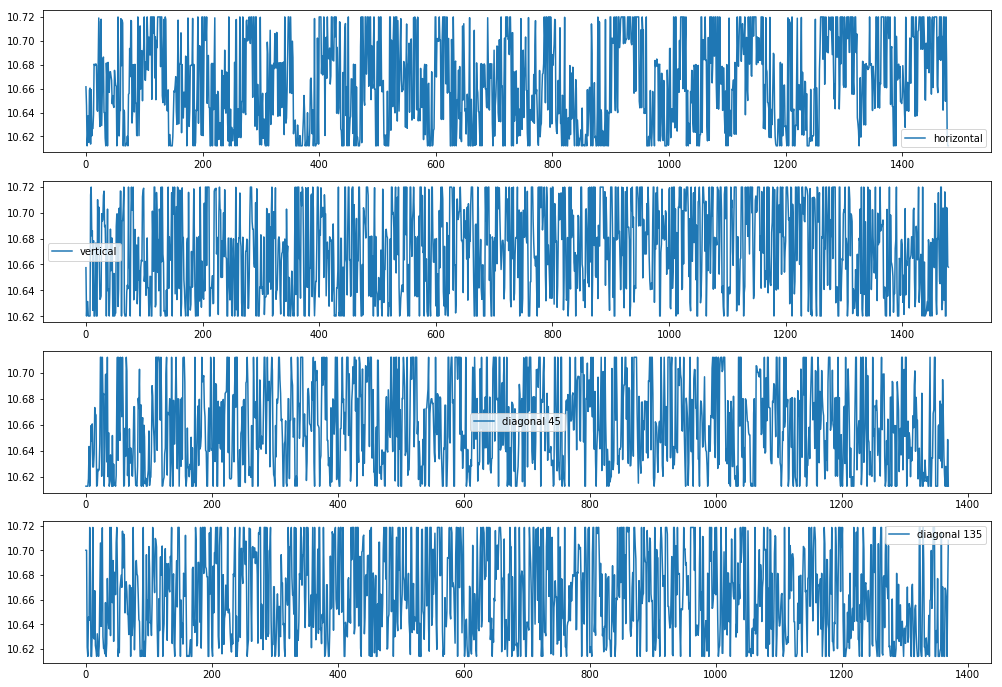

In [23]:
plot_preferred_distribution()

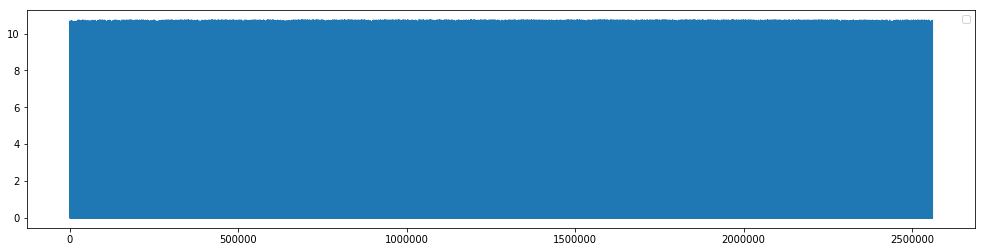

2243

In [24]:
weights = np.array(connections['L3_L3'].w)
weights = weights.reshape(n_L3*n_L3)
plt.figure(figsize=(17,4))
plt.plot(weights)
plt.legend(); plt.show()
gc.collect()

In [25]:
# save connections
save_connections()

input_L4 L4_L3 L3_L3 L3_L2 L2_L3 L3_L4 connections saved


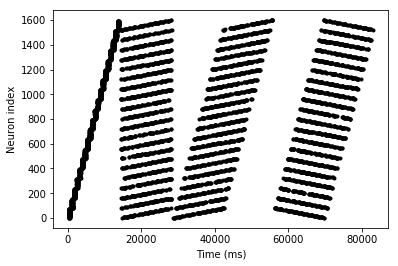

In [26]:
plot(spike_monitors['input'].t/ms, spike_monitors['input'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

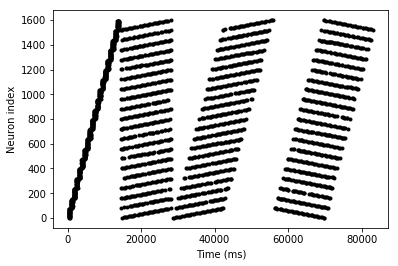

In [27]:
plot(spike_monitors['L4'].t/ms, spike_monitors['L4'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

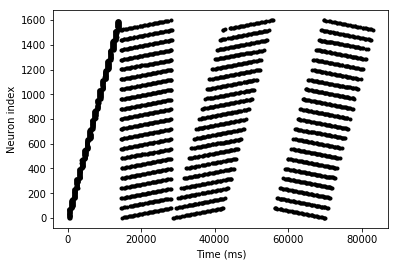

In [28]:
plot(spike_monitors['L3'].t/ms, spike_monitors['L3'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

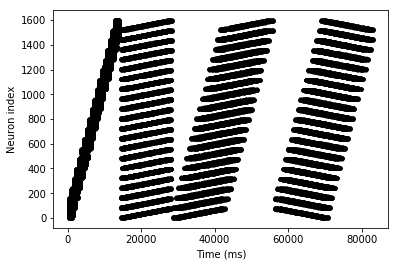

In [29]:
plot(spike_monitors['L2'].t/ms, spike_monitors['L2'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [30]:
gc.collect()

9383

In [31]:
# figure(figsize=(15, 4))
# plot(M['L2'].t/ms, M['L2'].v[8], label='L2')
# plot(M['L3'].t/ms, M['L3'].v[8], label='L3')
# legend()

In [32]:
unique(connections['L3_L3'].w)

array([-6.21037372e-03, -5.95156757e-03, -5.88969540e-03, ...,
        1.07197220e+01,  1.07197489e+01,  1.07197849e+01])

In [33]:
unique(connections['L3_L2'].w)

array([ 0.        , 50.00000012, 50.0000023 , ..., 50.0999826 ,
       50.09999248, 50.09999855])

In [34]:
weights = np.array(connections['L3_L3'].w)
weights = weights.reshape((n_L3,n_L3))